# Exp 16. 다음에 볼 영화 예측하기
## 💡 다른 기준으로 SessionId 정의 
* SessionId 정의를 다른 방식으로 해 본 주피터 노트북 파일이다.
* `UserId`와 `Time` 기준으로 Session Id를 정의하였다.
* (첫 파일에서는 `UserId`를 Session Id로 정의하여 진행하였다.)

---

# Step 0. 라이브러리 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# print(pandas.__version__)
# print(tensorflow.__version__)

---

# Step 1. 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [4]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
original_data_size = len(data)

data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* 추천 시스템을 구축할 때 가장 먼저 확인해볼 것은 유저수, 아이템 수이다.
* 해당 데이터의 유저 수는 6040개, 아이템 수는 3706개이다.

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

---

# Step 2. 데이터 전처리
* 위에서는 `UserId`를 기준으로 SessionID를 생성하였다.
* 하지만 우수프로젝트 코드를 확인하는데, `UserId`와 `Time`을 기준으로 SessionID를 생성하는 것을 보았다.
* `UserId`와 `Time`을 기준으로 하면 성능이 더 향상될까하여 한 번 진행해보았다.

## 2.1 Session Id

In [6]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [7]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,978300019,0,1
1,1,1270,5,978300055,1,3
2,1,1721,4,978300055,1,3
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,1
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159,1
1000205,6040,1921,4,997454464,471160,2
1000206,6040,1784,3,997454464,471160,2
1000207,6040,161,3,997454486,471161,1


In [8]:
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


## 2.2 Session Length

In [9]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

* `user_length`의 중앙값과 평균을 확인해보자.

In [10]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

* `session_length`의 최솟값과 최댓값을 확인해보자.

In [11]:
session_length.min(), session_length.max()

(1, 30)

* `session_length`의 99%의 분위수를 확인해보자.

In [12]:
session_length.quantile(0.99)

8.0

In [13]:
long_session = session_length[session_length == 28].index[0]
data[data['SessionId'] == long_session]

,UserId,ItemId,Rating,Time,SessionId
112250,731,2054,4,975527781,55112
112251,731,2,5,975527781,55112
112252,731,2087,5,975527781,55112
112253,731,788,4,975527781,55112
112254,731,1654,5,975527781,55112
112255,731,247,4,975527781,55112
112256,731,260,3,975527781,55112
112257,731,2100,5,975527781,55112
112258,731,2105,4,975527781,55112
112259,731,653,4,975527781,55112


* `session_length`를 시각적으로 나타내기 위해 `session_length` 기준 하위 99%까지의 분포 누적합을 확인해보자.

In [14]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()   # cumsum() : 누적합
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
dtype: float64

* `session_length`를 시각화해보자.

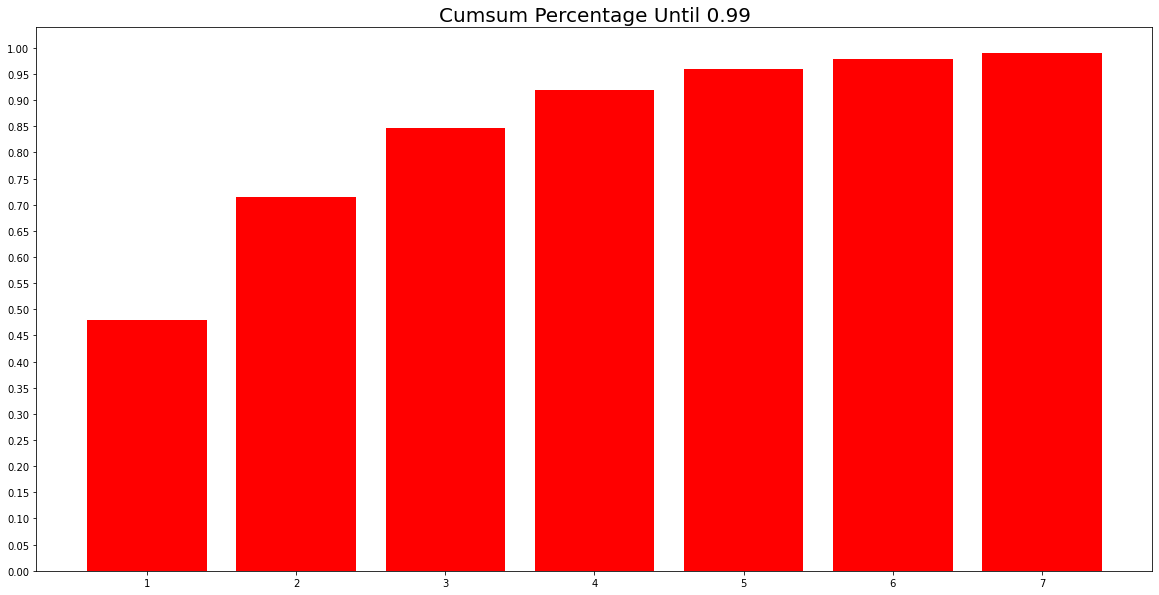

In [15]:
plt.figure(figsize=(20, 10))

plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

## 2.3 Time

In [16]:
import datetime

new_date = []
for i in data['Time']:
    new_time = datetime.datetime.fromtimestamp(i)
    new_date.append(new_time)
    
data['Time'] = new_date
data.head()

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2


* 2000년 4월부터 2003년 2월까지 대략 3년에 가까운 데이터가 있는 것을 확인하였다.

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [18]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

* 2.1에서 길이가 2314인 데이터의 Time을 변환한 데이터로 다시 확인해보았다.
* 동일한 날짜는 물론, 같은 시분초에 여러 개의 영화를 평가한 것으로 확인된다.

In [19]:
long_session = session_length[session_length == 28].index[0]
data[data['SessionId'] == long_session].head(50)

,UserId,ItemId,Rating,Time,SessionId
112250,731,2054,4,2000-11-29 19:56:21,55112
112251,731,2,5,2000-11-29 19:56:21,55112
112252,731,2087,5,2000-11-29 19:56:21,55112
112253,731,788,4,2000-11-29 19:56:21,55112
112254,731,1654,5,2000-11-29 19:56:21,55112
112255,731,247,4,2000-11-29 19:56:21,55112
112256,731,260,3,2000-11-29 19:56:21,55112
112257,731,2100,5,2000-11-29 19:56:21,55112
112258,731,2105,4,2000-11-29 19:56:21,55112
112259,731,653,4,2000-11-29 19:56:21,55112


* 따라서 해당 데이터는 물론이고 누적합 99% 이상인 데이터들도 이상치로 판단하고 제거한다.
* session_length의 99%의 분위수: 8

In [20]:
drop_index = session_length[session_length>8].index
data.drop(index=drop_index, inplace=True)

* 데이터의 개수가 1000209개에서 997848로 줄어들었다.

In [21]:
data.shape

(997848, 5)

## 2.4 Rating (Data Cleansing)
* 유저가 별점을 3점 미만으로 준 데이터는 선호하지 않는다고 가정하여 `Rating`이 3점 이상인 데이터만 남기고 제거하였다.
* 별점 3점 이상의 데이터 크기는 `834,528`이며, 비율은 `83.44%`를 차지한다.

In [22]:
data = data[data['Rating'] >= 3]
filltered_data_size = len(data)

print(f'전체 데이터 크기 : {original_data_size}')
print(f'별점 3점 이상의 데이터 크기 : {filltered_data_size}')
print(f'별점 3점 이상의 데이터 비율 : {filltered_data_size / original_data_size : .2%}')

전체 데이터 크기 : 1000209
별점 3점 이상의 데이터 크기 : 834528
별점 3점 이상의 데이터 비율 :  83.44%


## 2.5 train / valid / test data Split
* 모델 평가를 위해 valid set과 test set을 만들어보자.
* test 데이터는 마지막 5개월 전까지, valid 데이터도 5개월 전까지로 설정하여 분리하였다.

In [23]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - datetime.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - datetime.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [24]:
tr, test = split_by_date(data, n_days=150)

In [25]:
tr, val = split_by_date(tr, n_days = 150)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t 데이터 개수: {len(data)}\n'
          f'\t User 고유 개수: {data["UserId"].nunique()}\n'
          f'\t Item 고유 개수: {data["ItemId"].nunique()}\n'
          f'\t 데이터 시작 시간 : {data["Time"].min()}\n'
          f'\t 데이터 종료 시간 : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 데이터 개수: 821454
	 User 고유 개수: 6038
	 Item 고유 개수: 3620
	 데이터 시작 시간 : 2000-04-25 23:05:32
	 데이터 종료 시간 : 2002-05-04 09:26:12

* valid Set Stats Info
	 데이터 개수: 6897
	 User 고유 개수: 325
	 Item 고유 개수: 2075
	 데이터 시작 시간 : 2002-05-04 21:11:01
	 데이터 종료 시간 : 2002-10-01 09:36:33

* test Set Stats Info
	 데이터 개수: 6169
	 User 고유 개수: 310
	 Item 고유 개수: 1909
	 데이터 시작 시간 : 2002-10-01 19:26:51
	 데이터 종료 시간 : 2003-02-28 17:49:50



* train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다.

In [28]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

* 준비한 데이터를 저장하자.

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

---

# Step 3. 미니 배치의 구성
* Session-Parallel Mini-Batch를 구현하여 학습 속도의 저하가 최소화될 수 있도록 구성해보자.

## 3.1 Session Dataset
* 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만들어보자.

In [30]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

* train 데이터로 `SessionDataset` 객체를 만들고 인스턴스 변수를 살펴보자.

In [31]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


* `click_offsets`변수는 각 세션이 시작된 인덱스를 담고 있다.

In [32]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 821452, 821453, 821454], dtype=int32)

* `session_idx` 변수는 각 세션을 인덱싱한 `np.array`이다.

In [33]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 413306, 413307, 413308])

## 3.2 Session Data Loader
* `SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만들어보자.
* `__iter__`매서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`한다.
* `mask`는 후에 RNN Cell State를 초기화하는데 사용한다.

In [34]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [35]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [36]:
iter_ex = iter(tr_data_loader)

* 아래 셀을 반복 실행하면 `next`가 계속 다음 데이터를 만든다.

In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


---

# Step 4. 모델 구성

## 4.1 Evaluation Metrix
* 모델 성능 평가를 위한 지표를 확인해보자.
* `MRR`과 `Recall@k`를 사용해보자.

In [38]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 4.2 Model Architecture

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [40]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

* 모델에 사용할 하이퍼파라미터를 class 형식으로 관리해보자.
* 첫 파일에서 진행한 하이퍼파라미터 중 가장 성능이 좋았던 것으로 하여 학습시키고자 한다.

In [41]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [42]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3620)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550800    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3620)               184620    
Total params: 735,420
Trainable params: 735,420
Non-trainable params: 0
_________________________________________________________________


---

# Step 5. 모델 학습

In [44]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
train_model(model, args)

Evaluation:  25%|██▌       | 13/51 [00:10<00:29,  1.28it/s]


	 - Recall@20 epoch 1: 0.123197
	 - MRR@20    epoch 1: 0.038400



Evaluation:  25%|██▌       | 13/51 [00:08<00:24,  1.56it/s]


	 - Recall@20 epoch 2: 0.184495
	 - MRR@20    epoch 2: 0.066859



Evaluation:  25%|██▌       | 13/51 [00:08<00:23,  1.59it/s]


	 - Recall@20 epoch 3: 0.212139
	 - MRR@20    epoch 3: 0.077158



Evaluation:  25%|██▌       | 13/51 [00:07<00:23,  1.64it/s]


	 - Recall@20 epoch 4: 0.219952
	 - MRR@20    epoch 4: 0.082685



Evaluation:  25%|██▌       | 13/51 [00:08<00:24,  1.57it/s]


	 - Recall@20 epoch 5: 0.224760
	 - MRR@20    epoch 5: 0.083879



Evaluation:  25%|██▌       | 13/51 [00:08<00:24,  1.56it/s]


	 - Recall@20 epoch 6: 0.225962
	 - MRR@20    epoch 6: 0.086629



Evaluation:  25%|██▌       | 13/51 [00:08<00:24,  1.54it/s]


	 - Recall@20 epoch 7: 0.228365
	 - MRR@20    epoch 7: 0.087782



Evaluation:  25%|██▌       | 13/51 [00:07<00:23,  1.64it/s]


	 - Recall@20 epoch 8: 0.227163
	 - MRR@20    epoch 8: 0.087576



Evaluation:  25%|██▌       | 13/51 [00:08<00:23,  1.60it/s]


	 - Recall@20 epoch 9: 0.225361
	 - MRR@20    epoch 9: 0.086102



Evaluation:  25%|██▌       | 13/51 [00:07<00:23,  1.64it/s]

	 - Recall@20 epoch 10: 0.228365
	 - MRR@20    epoch 10: 0.085458



---

# Step 6. 모델 테스트
* 지금까지 작성한 모델이 테스트셋에 대해서 어느정도 성능을 내는지 검증해보자.

In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  27%|██▋       | 12/45 [00:07<00:19,  1.68it/s]

	 - Recall@20: 0.247396
	 - MRR@20: 0.090361

